## Rigid body 3 DOF
Devlop a system for a rigid body in 3 DOF and do a simualtion

In [1]:
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import sympy.physics.mechanics as me
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from substitute_dynamic_symbols import substitute_dynamic_symbols, find_name, find_derivative_name, lambdify, find_derivatives

from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
from sympy import cos,sin


In [3]:
x0,y0,z0 = me.dynamicsymbols('x0 y0 z0')
x01d,y01d,z01d = me.dynamicsymbols('x01d y01d z01d')
u,v,w = me.dynamicsymbols('u v w')
u1d,v1d,w1d = me.dynamicsymbols('u v w',1)


phi,theta,psi = me.dynamicsymbols('phi theta psi')
phi1d,theta1d,psi1d = me.dynamicsymbols('phi1d theta1d psi1d')

t = sp.symbols('t')

In [4]:
N = me.ReferenceFrame('N')

In [52]:
S = N.orientnew('S', 'Axis', [psi,N.z])

In [53]:
S.ang_vel_in(N)

psi'*N.z

In [54]:
S.ang_acc_in(N)

psi''*N.z

In [55]:
M = me.Point('M')  # Origo of measurement system
M.set_vel(N, 0)

O = me.Point('O') # Origo of ship
O.set_pos(M,x0*N.x + y0*N.y)
#O.set_vel(N,x01d*N.x + y01d*N.y)
O.set_vel(S,u*S.x + v*S.y)
#O.set_vel(S,0)
#O.v1pt_theory(M,N,S)

O.set_vel(N,(u*cos(psi) - v*sin(psi))*N.x + (u*sin(psi) + v*cos(psi))*N.y)
O.set_acc(N,(u1d*cos(psi) - v1d*sin(psi) + (-u*sin(psi)-v*cos(psi))*psi1d)*N.x + 
          (u1d*sin(psi) + v1d*cos(psi) + (u*cos(psi - v*sin(psi)))*psi1d)*N.y)

#O.set_vel(S,u*S.x + v*S.y)
#O.v1pt_theory(M,N,S)

In [56]:
velocity_matrix = O.vel(N).to_matrix(N)
velocity_matrix

Matrix([
[u(t)*cos(psi(t)) - v(t)*sin(psi(t))],
[u(t)*sin(psi(t)) + v(t)*cos(psi(t))],
[                                  0]])

In [57]:
acceleration_matrix = O.acc(N).to_matrix(N)
acceleration_matrix

Matrix([
[(-u(t)*sin(psi(t)) - v(t)*cos(psi(t)))*psi1d(t) - sin(psi(t))*Derivative(v(t), t) + cos(psi(t))*Derivative(u(t), t)],
[   psi1d(t)*u(t)*cos(psi(t) - v(t)*sin(psi(t))) + sin(psi(t))*Derivative(u(t), t) + cos(psi(t))*Derivative(v(t), t)],
[                                                                                                                  0]])

In [58]:
P = me.Point('P')
#P.set_vel(S,0)
P.set_pos(M,x0*S.x + y0*S.y)

In [88]:
#P.v1pt_theory(M,N,S).to_matrix(N)

In [89]:
P = me.Point('P')
P.set_pos(M,x0*N.x + y0*N.y)
P.set_vel(N,x01d*N.x + y01d*N.y)

In [90]:
O = me.Point('O')
O.set_vel(S,u*S.x + v*S.y)
O.set_pos(M,x0*N.x + y0*N.y)
O.set_vel(N,x0*N.x + y0*N.y)

#S.set_pos(P,x0*S.x + y0*S.y)

In [91]:
O.v1pt_theory(P,N,S).to_matrix(N)

Matrix([
[u(t)*cos(psi(t)) - v(t)*sin(psi(t)) + x01d(t)],
[u(t)*sin(psi(t)) + v(t)*cos(psi(t)) + y01d(t)],
[                                            0]])

## Mass

In [11]:
mass = sp.symbols('m')
#x_g, y_g, z_g = sp.symbols('x_g y_g z_g')

In [12]:
#c_og = me.Point('c_og')
#c_og.set_pos(O,x_g*S.x + y_g*S.y + z_g*S.z)
#c_og.set_vel(S,0)

In [13]:
#c_og.v2pt_theory(O,N,S)

## Inertia

In [14]:
I_xx, I_yy, I_zz = sp.symbols('I_xx, I_yy, I_zz')
body_inertia_dyadic = me.inertia(S, ixx=I_xx, iyy=I_yy, izz=I_zz)
body_inertia_dyadic

I_xx*(S.x|S.x) + I_yy*(S.y|S.y) + I_zz*(S.z|S.z)

In [15]:
body_inertia_dyadic.to_matrix(S)

Matrix([
[I_xx,    0,    0],
[   0, I_yy,    0],
[   0,    0, I_zz]])

In [16]:
body_central_inertia = (body_inertia_dyadic, O)

In [17]:
body = me.RigidBody('Rigid body', masscenter=O, frame = S,
                      mass=mass, inertia=body_central_inertia)

## Forces

In [18]:
fx, fy, fz, mx, my, mz = sp.symbols('f_x f_y f_z m_x m_y m_z')

In [19]:
force_vector = fx*S.x + fy*S.y 
torque_vector = mz*S.z

In [20]:
force = (O, force_vector)
torque = (S, torque_vector)

## Equations of Motion

In [21]:
coordinates = [x0, y0, psi]
speeds = [u, v, psi1d]

In [22]:
kinematical_differential_equations = [x0.diff() - velocity_matrix[0],                                      
                                      y0.diff() - velocity_matrix[1],
                                      psi.diff() - psi1d,
                                     ]

In [23]:
kinematical_differential_equations

[-u(t)*cos(psi(t)) + v(t)*sin(psi(t)) + Derivative(x0(t), t),
 -u(t)*sin(psi(t)) - v(t)*cos(psi(t)) + Derivative(y0(t), t),
 -psi1d(t) + Derivative(psi(t), t)]

In [24]:
#?me.KanesMethod

In [25]:
kane = me.KanesMethod(N, coordinates, speeds, kinematical_differential_equations)

In [26]:
loads = [force,
         torque]

In [27]:
bodies = [body]
fr, frstar = kane.kanes_equations(bodies, loads)

In [28]:
constants = [I_xx, I_yy, I_zz,mass]

specified = [fx, fy, mz]  # External force/torque

right_hand_side = generate_ode_function(kane.forcing_full, coordinates,
                                        speeds, constants,
                                        mass_matrix=kane.mass_matrix_full,specifieds=specified)

In [29]:
coordinates_ = [0, 0, 0,]
speeds_ = [0, 0, 0,]

start = np.array(coordinates_+speeds_)

t_ = 0.
force_torque = [1,0,0]
numerical_specified = np.array(force_torque)

I_xx_ = 1
I_yy_ = 1
I_zz_ = 1
mass_ = 1

numerical_constants = np.array([I_xx_, I_yy_, I_zz_,mass_])

right_hand_side(start, t_, numerical_specified, numerical_constants)

array([0., 0., 0., 1., 0., 0.])

In [30]:
def simulate(t,force_torque, I_xx,I_yy,I_zz,mass, initial_coordinates = [0, 0, 0,], 
             initial_speeds = [0, 0, 0,]):
    
    start = np.array(initial_coordinates+initial_speeds)
    
    numerical_specified = force_torque
        
    numerical_constants = np.array([I_xx, I_yy, I_zz, mass])
    
    df = pd.DataFrame(index=t)
    y = odeint(right_hand_side, start, t, args=(numerical_specified, numerical_constants))
    
    for i,symbol in enumerate(coordinates+speeds):
        name = symbol.name
        df[name] = y[:,i]
        
    return df

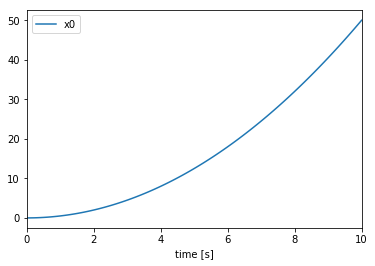

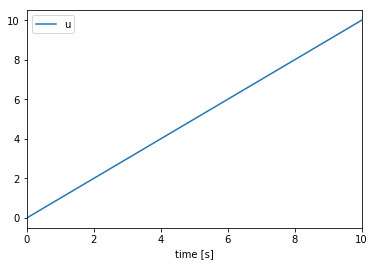

In [31]:
t = np.linspace(0,10,100)

df = simulate(t=t, force_torque=[1,0,0],I_xx=1, I_yy=1, I_zz=1, mass=1)


fig,ax = plt.subplots()
df.plot(y='x0', ax=ax);
ax.set_xlabel('time [s]')

fig,ax = plt.subplots()
df.plot(y='u', ax=ax);
ax.set_xlabel('time [s]');

In [32]:
def track_plot(df,ax, l=1, time_step='1S'):
    
    df.plot(x='y0', y='x0',ax = ax)
    
    df_ = df.copy()
    df_.index = pd.TimedeltaIndex(df_.index,unit='s')
    df_ = df_.resample(time_step).first()   
    
    def plot_body(row):
        x = row['y0']
        y = row['x0']
        psi = row['psi']
        xs = [x-l/2*np.sin(psi),x+l/2*np.sin(psi)]
        ys = [y-l/2*np.cos(psi),y+l/2*np.cos(psi)]
        ax.plot(xs,ys,'k-')
    
    for index,row in df_.iterrows():
        plot_body(row)
    
    ax.set_xlabel('y0')
    ax.set_ylabel('x0')
    ax.axis('equal')
    
    
        
    
    

c:\dev\motion-to-acceleration\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


Text(0, 0.5, 'psi')

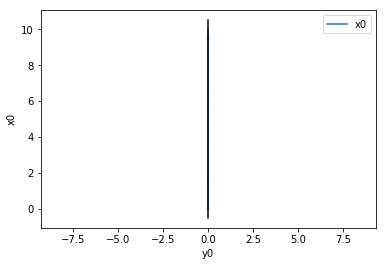

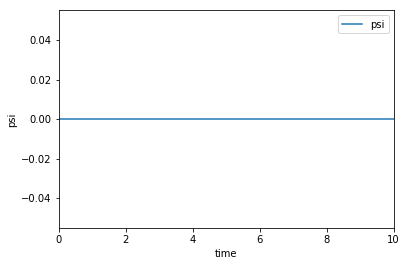

In [33]:
t = np.linspace(0,10,100)

df = simulate(t=t, force_torque=[0,0,0],I_xx=1, I_yy=1, I_zz=1, mass=1,
              initial_speeds=[1,0,0,],initial_coordinates=[0, 0, 0,])


fig,ax = plt.subplots()
track_plot(df,ax)


fig,ax = plt.subplots()
df.plot(y='psi', ax=ax);
ax.set_xlabel('time')
ax.set_ylabel('psi')



Text(0, 0.5, 'psi')

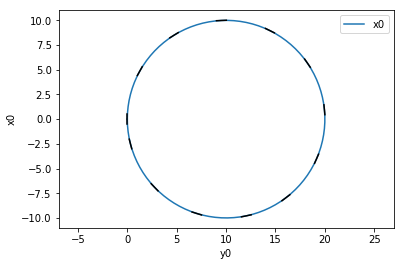

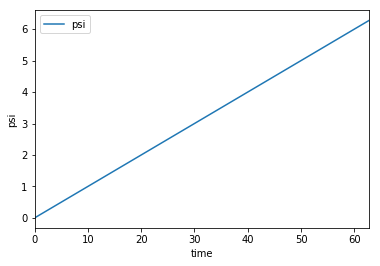

In [41]:

radius = 10  # Radius of rotation [m]
w = 0.1  # Angle velocity [rad/s]
V = radius*w  # Speed of point [m/s]
t = np.linspace(0,2*np.pi/w,100)

mass=1

expected_acceleration = -radius*w**2
expected_force = mass*expected_acceleration


df = simulate(t=t, force_torque=[0,-expected_force,0],I_xx=1, I_yy=1, I_zz=1, mass=mass,
              initial_speeds=[V,0,w,],initial_coordinates=[0, 0, 0,])


fig,ax = plt.subplots()
track_plot(df,ax, time_step = '5S')


fig,ax = plt.subplots()
df.plot(y='psi', ax=ax);
ax.set_xlabel('time')
ax.set_ylabel('psi')